# A movie snob recommender - II. Exploratory Data Analysis

## 0. Introduction

This is an EDA of movie ratings aiming to elucidate any factors that might be associated with the rating of a movie, and of canonical status.

1. Do some exploratory analyses of the Grouplens dataset ratings over time
2. Look at differences in ratings between 1,001 and non-1,001 movies.
3. Examine some possible indicators of snobbery

#### Loading the data
Re-load the data from pickled file. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

ms_df = pd.read_pickle("moviesnob_df.pkl")

ms_df.head()
# Release year has some missing values, hence it is a float

,userId,movieId,rating,rating_date,canonical,tmdbId,release_date,rating_days_after,rating_year,release_year
0,1,307,3.5,2009-10-27,1.0,108.0,1993-01-10,NaT,2009,1993.0
1,1,481,3.5,2009-10-27,0.0,10909.0,1993-09-01,NaT,2009,1993.0
2,1,1091,1.5,2009-10-27,0.0,8491.0,1989-07-05,NaT,2009,1989.0
3,1,1257,4.5,2009-10-27,0.0,13667.0,1985-10-11,NaT,2009,1985.0
4,1,1449,4.5,2009-10-27,0.0,16448.0,1996-08-21,4815 days,2009,1996.0


In [2]:
ms_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27729729 entries, 0 to 27753443
Data columns (total 10 columns):
userId               int64
movieId              int64
rating               float64
rating_date          datetime64[ns]
canonical            float64
tmdbId               float64
release_date         datetime64[ns]
rating_days_after    timedelta64[ns]
rating_year          int64
release_year         float64
dtypes: datetime64[ns](2), float64(4), int64(3), timedelta64[ns](1)
memory usage: 2.3 GB


In [3]:
# Basics look at the ratings
pd.set_option('float_format', '{:.2f}'.format)
ms_df.loc[:,['rating', 'canonical']].describe()

,rating,canonical
count,27729729.00,27729729.00
mean,3.53,0.28
std,1.07,0.45
min,0.50,0.00
25%,3.00,0.00
50%,3.50,0.00
75%,4.00,1.00
max,5.00,1.00


## 1. Overview of movie ratings

Canonical movies (which account for only 2% of possible titles) are rated disproportionately highly (28% of ratings are for canonical movies).

The mean rating is the classic 'David Stratton three-and-a-half stars'. However, as shown below, the modal rating is 4 out of 5, and the ratings are left skewed.

(One potential explanation for the left skew is a simple selection bias whereby people use heuristics to weed out movies they would strongly dislike. A second potential explanation is that only people who like canonical movies provide ratings.)

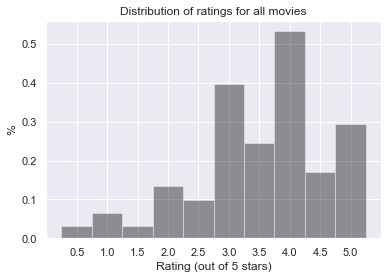

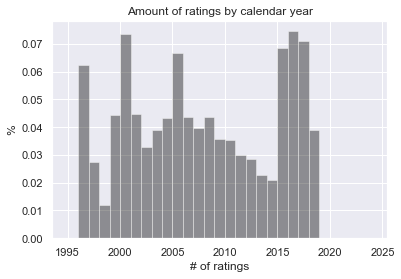

In [4]:
# What were the proportions of each rating overall?
sns.set()
bins = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]
_ = sns.distplot(ms_df.rating, kde=False, color="black", bins=bins, norm_hist=True)
_ = plt.title('Distribution of ratings for all movies')
_ = plt.ylabel('%')
_ = plt.xlabel('Rating (out of 5 stars)')
_ = plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.show()

# What were the proportion of ratings each calendar year?
_ = sns.distplot(ms_df.rating_year, kde=False, color="black", bins=list(range(1995,2025)), norm_hist=True)
_ = plt.title('Amount of ratings by calendar year')
_ = plt.ylabel('%')
_ = plt.xlabel('# of ratings')
#_ = plt.xticks([0,1000,2000,3000])
plt.show()

# We also want a long tail plot by movie kind (group by movieId and then plot)
#group_by(movieId).count()


As shown below, the ratings have the typical long-tail of rating datasets.
If the list is limited to movies with a minimum rating count of 100, 10K movies remain.

In [7]:
# Aggregrating the ratings by movie for analyses
by_movie = ms_df.groupby('movieId').agg({'rating': ['count', 'mean'], 'canonical': 'first'})
by_movie.columns = by_movie.columns.droplevel(0)
by_movie = by_movie.rename(columns={'count':'ratings_f','mean':'ratings_mean','first':'canonical'})
print(by_movie.head())

         ratings_f  ratings_mean  canonical
movieId                                    
1            68468          3.89       1.00
2            27142          3.25       0.00
3            15585          3.17       0.00
4             2989          2.87       0.00
5            15473          3.08       0.00


In [8]:
# Showing the typical long-tail of movie ratings
min_rating_count = 10
ratings_over_min = by_movie[by_movie.ratings_f > min_rating_count].sort_values(
    by='ratings_f', ascending=False)
print(ratings_over_min.head())
#_ = ratings_over_min.ratings_f.plot()
#_ = plt.title ('Distribution of number of ratings per view (min. N=100)')
#_ = plt.xlabel ('Movie')
#_ = plt.ylabel ('NUmber of ratings')
#plt.show()
#print('{:.0f} movies have at least {} ratings'.format(ratings_count_over_delta.shape[0], 
#      min_rating_count))

         ratings_f  ratings_mean  canonical
movieId                                    
318          97998          4.42       1.00
356          97039          4.06       1.00
296          92405          4.17       1.00
593          87898          4.15       1.00
2571         84544          4.15       1.00


Plotting the mean rating of each movie results in a ridged distribution, but if the minimum number of ratings is increased (even to two ratings) then these ridges disappear (the bumps are for movies that are rated only once).
The mean ratings are left-skewed (unsurprisingly similar to the unaggregated distributions).


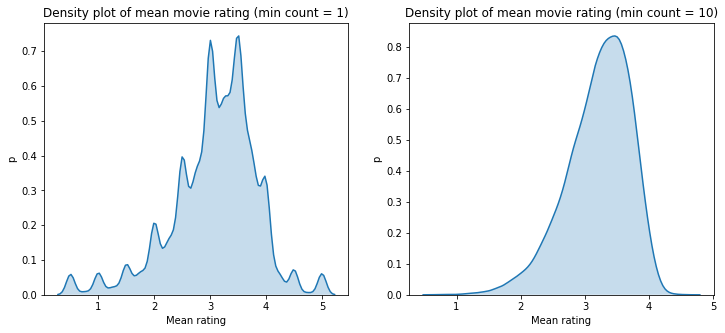

In [9]:
# Distribution of mean movie ratings
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig1 = sns.kdeplot(data=by_movie.ratings_mean, shade=True, ax=ax1, legend=None)
fig1.set_title('Density plot of mean movie rating (min count = 1)')
fig1.set_xlabel('Mean rating')
fig1.set_ylabel('p')

fig2 = sns.kdeplot(data=ratings_over_min.ratings_mean, shade=True, ax=ax2, legend=None)
fig2.set_title('Density plot of mean movie rating (min count = {})'.format(min_rating_count))
fig2.set_xlabel('Mean rating')
fig2.set_ylabel('p')

plt.show()

In [10]:
# The following makes a dataset with movie ratings grouped by how long after release the rating was made
pos_df = ms_df[ms_df.rating_days_after > dt.timedelta(minutes=0)].dropna().set_index(
    'rating_days_after').groupby('release_year').resample('365D').mean().reset_index(level='release_year', drop=True)

# This resamples the rating date to get the ratings in a calendar month
main_df = ms_df.set_index('rating_date').rating.resample('M').mean()
#print(pos_df.head())

The two charts below show the rating of movies across time. Ratings from 1999 onward (once ratings become more common), are flat. Similarly, as movies age (panel on the right), the rating does not change.

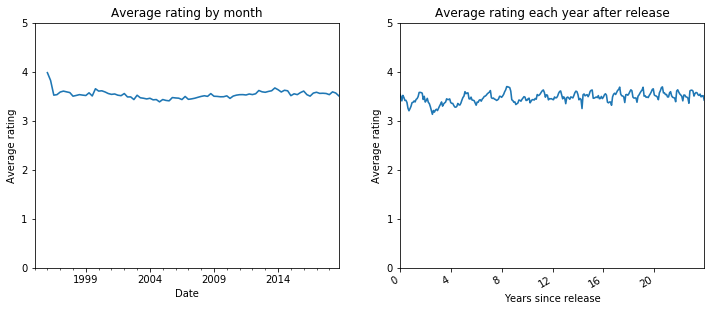

In [11]:
# Looking at ratings across time
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# Average rating per year (I use the SD CI because the bootstrapping is time consuming)
fig1 = ms_df.set_index('rating_date').rating.resample('3M').mean().plot(linewidth=1.6, ax=ax1)
fig1.set_xlabel('Date')
fig1.set_ylabel('Average rating')
fig1.set_title('Average rating by month')
fig1.set_ylim(0,5)

# Average rating since time of release
fig2 = pos_df.rating.plot(linewidth=1.6, ax=ax2)
fig2.set_xlabel('Years since release')
fig2.set_ylabel('Average rating')
fig2.set_title('Average rating each year after release')
fig2.set_xticklabels([0,4,8,12,16,20,24])
fig2.set_ylim(0,5)

plt.show()

Below is a quick regression to further illustrate that movie ratings don't (on average) change over time. The coefficient is essentially zero.

In [12]:
### A quick regression to see if there is a trend across time since days of release
from sklearn.linear_model import LinearRegression
X = pos_df.reset_index().rating_days_after.values.reshape(-1,1)
y = pos_df.rating.values.reshape(-1,1)
lm1 = LinearRegression(fit_intercept=True, normalize=True)
lm1.fit(X, y)
print('Intercept: {:.2f}'.format(lm1.intercept_[0]))
print('Coefficient for days since release: {:.6f}'.format(lm1.coef_[0][0]))
print('As can be seen in the coefficient above, mean movie ratings remain constant across time.')

Intercept: 3.49
Coefficient for days since release: -0.000000
As can be seen in the coefficient above, mean movie ratings remain constant across time.


If the movies are plotted by year of release, the trends do not change over time.

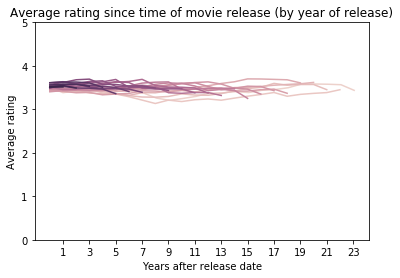

In [13]:
# Sample code for plotting each year
pos_df2 = pos_df.reset_index()
pos_df2.rating_days_after = pos_df2.rating_days_after.apply(lambda x: x.days)
#print(pos_df2.head())

_ = sns.lineplot(x="rating_days_after", y="rating",hue="release_year", data=pos_df2, legend=None)
_ = plt.xticks(ticks=list(range(365, 9125, 730)), labels=list(range(1,25,2)))
_ = plt.xlabel('Years after release date')
_ = plt.ylabel('Average rating')
_ = plt.title('Average rating since time of movie release (by year of release)')
_ = plt.ylim(0,5)
plt.show()
# prints separate plots but could add an ax command and also a line color one
#for year, value in pos_df2.groupby(['release_year']):
#    _ = value.plot(kind='line', x='rating_days_after', y='rating', label=year)

#plt.legend(loc='best')
#plt.show()

## 2. The effect of canonicity

In general, canonical movies are more highly rated than non-canonical movies (see chart below).


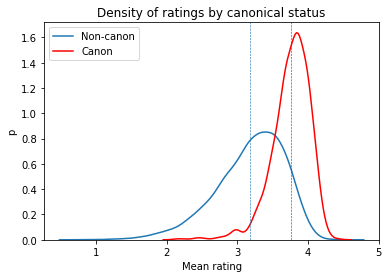

Mean of distributions shown as dotted lines


In [14]:
# Plotting the distributions of ratings by canonical status
sns.kdeplot(ratings_over_min[ratings_over_min.canonical == 0].ratings_mean,label='Non-canon')
sns.kdeplot(ratings_over_min[ratings_over_min.canonical == 1].ratings_mean,label='Canon', 
            color='r')

plt.title('Density of ratings by canonical status')
plt.xlabel('Mean rating')
plt.ylabel('p')
plt.axvline(np.mean(ratings_over_min[ratings_over_min.canonical == 0].ratings_mean), 
            linewidth=0.6, linestyle='--')
plt.axvline(np.mean(ratings_over_min[ratings_over_min.canonical == 1].ratings_mean),
            linewidth=0.6, linestyle='--', color='r')
plt.show()
print("Mean of distributions shown as dotted lines")

The gap between canonical and non-canonical movies might be slightly narrowing over time.

More interestingly, the mean rating of canonical and non-canonical movies decreases as the movies age. This may be a result of a selection effect on non-canonical movies (the worst cease, but that needs some hard proof).

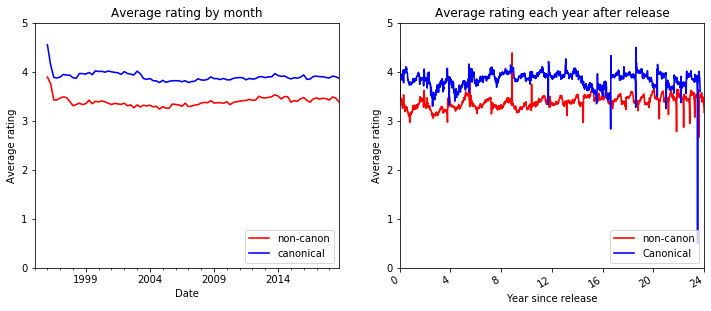

In [16]:
# Looking at ratings across time
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

fig1 = ms_df[ms_df.canonical == 0].set_index('rating_date').rating.\
resample('3M').mean().plot(linewidth=1.6, ax=ax1, color='r', label='non-canon')
fig1 = ms_df[ms_df.canonical == 1].set_index('rating_date').rating.\
resample('3M').mean().plot(linewidth=1.6, ax=ax1, color='b', label='canonical')
fig1.set_xlabel('Date')
fig1.set_ylabel('Average rating')
fig1.set_title('Average rating by month')
fig1.legend(loc='lower right')
fig1.set_ylim(0,5)

# Average rating since time of release
# First make the dataset
canon_since_release = ms_df[ms_df.rating_days_after > dt.timedelta(minutes=0)].dropna().\
set_index('rating_days_after').groupby(['canonical', 'release_year']).resample('90D').\
mean().reset_index(level=['canonical','release_year'], drop=True)
canon_since_release = canon_since_release.reset_index().dropna()
canon_since_release['days'] = canon_since_release.rating_days_after.apply(
    lambda x: x.days)

# Then plot
fig2 = canon_since_release[canon_since_release.canonical == 0].set_index(
    'rating_days_after').rating.plot(linewidth=1.6, ax=ax2, color='r', label='non-canon')
fig2 = canon_since_release[canon_since_release.canonical == 1].set_index(
    'rating_days_after').rating.plot(linewidth=1.6, ax=ax2, color='b', label='Canonical')

#fig2 = sns.lineplot(x="days", y="rating",hue="canonical", data=
#                    canon_since_release, legend='full')
fig2.set_xlabel('Year since release')
fig2.set_ylabel('Average rating')
fig2.set_title('Average rating each year after release')
fig2.set_xticklabels([0,4,8,12,16,20,24])
fig2.set_ylim(0,5)
fig2.legend(loc='lower right')
plt.show()

To look at the viewing habits for canonicity, the data needed to be grouped by user.

In [17]:
# Group by user first to get proportion and count of canonical
by_user = ms_df.groupby('userId').agg({'rating': ['count', 'mean'], 'canonical': 'sum'})
by_user.columns = by_user.columns.map('_'.join)

# Calculate the canon proportion column
#size_of_canon = 1222 #This is the length of the canonical list
by_user['canon_prop'] = by_user.canonical_sum / by_user.rating_count


Plots revealed....

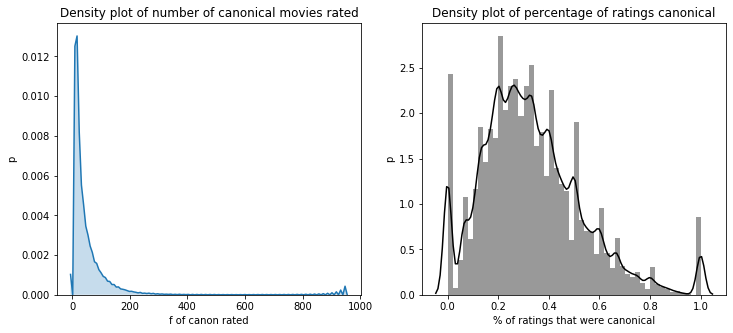

In [18]:
# Distribution of mean movie ratings
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
#fig1 = sns.distplot(by_user.canonical_sum, kde=False, color="black", norm_hist=True)
fig1 = sns.kdeplot(data=by_user.canonical_sum, shade=True, ax=ax1, legend=None)
fig1.set_title('Density plot of number of canonical movies rated')
fig1.set_xlabel('f of canon rated')
fig1.set_ylabel('p')

#fig2 = sns.kdeplot(data=by_user.canon_prop, shade=True, ax=ax2, legend=None)
fig2 = sns.distplot(by_user.canon_prop, kde=True, color="black", norm_hist=True)
fig2.set_title('Density plot of percentage of ratings canonical')
fig2.set_xlabel('% of ratings that were canonical')
fig2.set_ylabel('p')

plt.show()

Inspection of the proportional variable suggested that those with high proportions had very few ratings. Removing those smoothed out the curve (see below). (NB The effect of low frequency raters is similar to the effect of infrequently rated movies.)

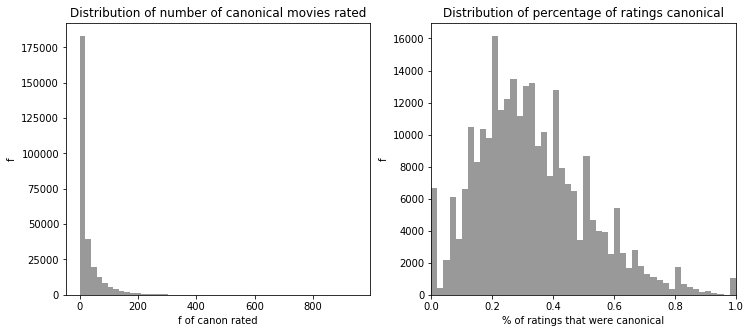

In [26]:
# The code below is to inspect patterns among users who exclusively rated canonical movies.
#by_user[by_user.canon_prop > 0.95].sort_values(by='rating_count', ascending=True)

min_rating_count = 5
by_user_more = by_user[by_user.rating_count >= min_rating_count]
#by_user_more[by_user_more.canon_prop > 0.95].sort_values(by='rating_count', ascending=True)

# Distribution of mean movie ratings
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig1 = sns.distplot(by_user.canonical_sum, kde=False, color="black", ax=ax1)
#fig1 = sns.kdeplot(data=by_user_more.canonical_sum, shade=True, ax=ax1, legend=None)
fig1.set_title('Distribution of number of canonical movies rated')
fig1.set_xlabel('f of canon rated')
fig1.set_ylabel('f')

#fig2 = sns.kdeplot(data=by_user.canon_prop, shade=True, ax=ax2, legend=None)
fig2 = sns.distplot(by_user_more.canon_prop, kde=False, color="black", ax=ax2)
fig2.set_title('Distribution of percentage of ratings canonical')
fig2.set_xlim(0,1)
fig2.set_xlabel('% of ratings that were canonical')
fig2.set_ylabel('f')

plt.show()

### 3. Indicators of snobbery
Snobbery should have both an outcome (a behavioral pattern) and a cause (a cognitive underpinning and/or individual difference). Both the outcomes and some cognitive features can be generated from a set of ratings, without requiring other user information. In this next section, we engineer the features, starting with outcomes and then looking at causes.

### 3.1 Outcomes of snobbery

There are many different possible measures of how snobby a person is, but we have to choose some impact of this snobbery. We consider the following outcomes:

1. Ratings of canonical movies.
1a. Mean rating for canonical movies
1b. Mean difference in canonical versus not (use a t-statistic on the difference within individuals between canon and non-canon ratings )  

2. Watching of canon.
2a. How many canonical movies has this person rated?
2b. What percentage of their ratings are of the canon?
Both of these latter classes have already been constructed.

In [ ]:
# Constructing the matrix requires a by-user approach. We already have the beginnings but need the means and SDs
#of canonical and non-canonical movies for each user.

# Group by two variables, create the means and SDs, and then unstack and rename.
double_stack = ms_df.groupby(['userId','canonical'])
# from here
canonical_mean_sds = double_stack['rating'].agg({'mean' : np.mean, 'sd' : np.std, 'n': 'count'}).unstack()
canonical_mean_sds.columns = ['canonical_mean', 'noncanon_mean','canonical_sd','noncanon_sd','canon_n','noncanon_n']

# Join the new canonical mean to the main file
by_user['canonical_mean'] = canonical_mean_sds['canonical_mean']

# Make the t-stat.
canonical_mean_sds['canon_pref_meandiff']= canonical_mean_sds.canonical_mean - canonical_mean_sds.noncanon_mean
canonical_mean_sds['canon_pref_sd']= np.sqrt(( (canonical_mean_sds.canonical_sd ** 2 * canonical_mean_sds.canon_n) +
                                        (canonical_mean_sds.noncanon_sd ** 2 * 
                                         canonical_mean_sds.noncanon_n))/(canonical_mean_sds.canon_n +
                                                                          canonical_mean_sds.noncanon_n))
canonical_mean_sds['canon_pref_stat'] = canonical_mean_sds['canon_pref_meandiff'] / canonical_mean_sds['canon_pref_sd']

by_user['canon_pref_stat'] = canonical_mean_sds['canon_pref_stat']
by_user['canon_pref_meandiff'] = canonical_mean_sds['canon_pref_meandiff']


Here we look at the distribution of these outcomes (noting that the latter two were also displayed earlier).

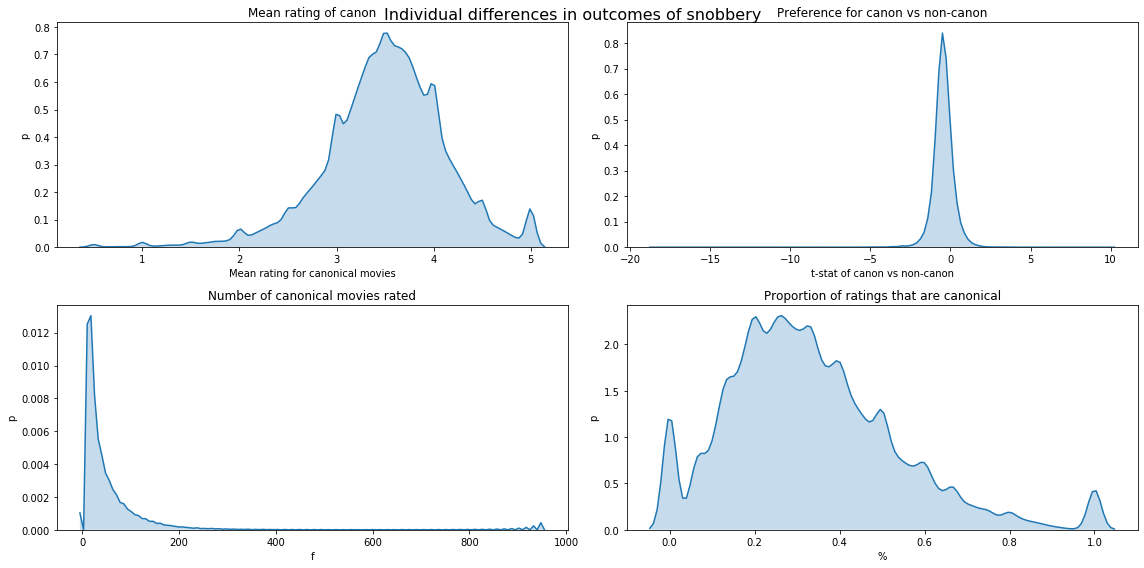

In [322]:
# Plots for them

f, axes = plt.subplots(2, 2, figsize=(16,8))
fig1 = sns.kdeplot(data=by_user.canonical_mean, shade=True, ax=axes[0,0], legend=None)
fig1.set_title('Mean rating of canon')
fig1.set_xlabel('Mean rating for canonical movies')
fig1.set_ylabel('p')

fig2 = sns.kdeplot(data=by_user.canon_pref_stat, shade=True, ax=axes[0,1], legend=None)
fig2.set_title('Preference for canon vs non-canon')
fig2.set_xlabel('t-stat of canon vs non-canon')
fig2.set_ylabel('p')

fig3 = sns.kdeplot(data=by_user.canonical_sum, shade=True, ax=axes[1,0], legend=None)
fig3.set_title('Number of canonical movies rated')
fig3.set_xlabel('f')
fig3.set_ylabel('p')

fig4 = sns.kdeplot(data=by_user.canon_prop, shade=True, ax=axes[1,1], legend=None)
fig4.set_title('Proportion of ratings that are canonical')
fig4.set_xlabel('%')
fig4.set_ylabel('p')

plt.suptitle('Individual differences in outcomes of snobbery', fontsize=16)
plt.subplots_adjust(top=4)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
plt.show()

### 3.2 Snobbery indices
I started thinking about the stereotypes of snobs and wondered if each of these could be turned into an index. Each index could then be correlated with the outcomes listed above.

1. I like your old stuff better than your new stuff.
This index is about generally liking older things more than newer things.

2. I loved it, I hated it (aka the <a href="https://www.youtube.com/watch?v=NpYEJx7PkWE">Statler-Waldorf</a> criterion).
This index rates the extent to which people are extreme in their views (compared to centrist). Two options come to mind here:
2a. Kurtosis. This might not work due to having low numbers of ratings and a five-point rating system.
2b. Proportion of end-of-scale ratings. We use this one.

3. Obscurist tendencies.
Liking lesser known films more than well-known films.

4. Contrariness.
Being contrary to popular opinion (discrepancy of an individual's rating of a movie from that movie's average rating).

Two other things that I think are less relevant but could be worth exploring later on:
5. Watching by director. The tendency to watch the entire set of films by a director.
6. "I loved you the first moment I saw you" (aka the Fountainhead index).
This one is perhaps a little harder to explain but it's the propensity of each person to love the first movie they see by a director the most. There is a similar tendency in music to give undue weight to the first album you hear by a great band.

In [ ]:
# Define each of the custom indexes

# 1. "I like the old stuff better than the new stuff"
# Correlation between rating and age of movie
by_user['newold_r'] = ms_df[['rating','release_year','userId']].groupby('userId').corr().unstack().rating.release_year
# 2. Statler-Waldorf criterion
# Relative proportion of 1&5 versus 2,3,4
grumpy = ms_df.groupby(['userId','rating']).agg({'rating':'count'}).unstack()
grumpy.columns =['halfstar','onestar','one5star','twostar','two5star','threestar','three5star','fourstar','four5star'
               ,'fivestar']
grumpy['extremes'] = np.nansum([grumpy.halfstar, grumpy.onestar, grumpy.fivestar], axis=0) 
grumpy['all_sum'] = np.nansum([grumpy.halfstar, grumpy.onestar, grumpy.one5star, grumpy.twostar,grumpy.two5star,
                               grumpy.threestar, grumpy.three5star, grumpy.fourstar, grumpy.four5star, grumpy.fivestar
                              ], axis=0)
by_user['statler_waldorf'] = grumpy.extremes / grumpy.all_sum

# 3. Obscurists
# Correlation between personal rating for a movie and number of ratings for that movie (should be negative)
# Calculate the number of ratings of each movie
num_ratings_by_movie = ms_df[['rating','movieId']].groupby('movieId').count()
num_ratings_by_movie.columns = ['times_rated']
# Broadcast the number of ratings of each movie to each rating
ms_df = pd.merge(ms_df, num_ratings_by_movie, how='left', on='movieId')
# calculate the correlation by user and add that as new column
by_user['obscurist']=ms_df[['rating','times_rated','userId']].groupby('userId').corr().unstack().times_rated.rating

# 4. Contrariness
# Average deviation of someone's rating from the mean
# calculate mean rating by movie
mean_ratings_by_movie = ms_df[['rating','movieId']].groupby('movieId').mean()
mean_ratings_by_movie.columns = ['movie_mean_rating']
# Join the movie's mean rating to each individual rating
ms_df = pd.merge(ms_df, mean_ratings_by_movie, how='left', on='movieId')
# calculate how far each rating is from the average (just the mean deviation)
ms_df['rating_deviation'] = abs(ms_df.rating - ms_df.movie_mean_rating)
#get an average of the deviance for each user as a new column
by_user['contrariness']=ms_df[['rating_deviation','userId']].groupby('userId').mean()

# Pickle that for later.
by_user.to_pickle('moviesnob_by_user_df.pkl')

We then examine the distributions of all four of these indicators.

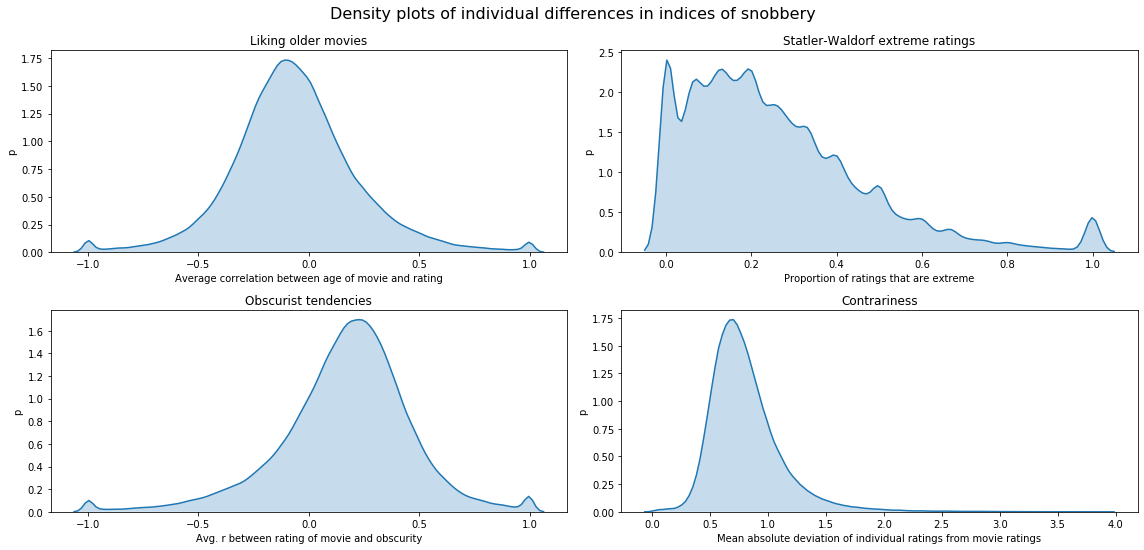

In [321]:
# Plots of the indices

# Density plot of Liking old vs new
f, axes = plt.subplots(2, 2, figsize=(16,8))
fig1 = sns.kdeplot(data=by_user.newold_r, shade=True, ax=axes[0,0], legend=None)
fig1.set_title('Liking older movies')
fig1.set_xlabel('Average correlation between age of movie and rating')
fig1.set_ylabel('p')

# Density plot of Statler-Waldorf extremity
fig2 = sns.kdeplot(data=by_user.statler_waldorf, shade=True, ax=axes[0,1], legend=None)
fig2.set_title('Statler-Waldorf extreme ratings')
fig2.set_xlabel('Proportion of ratings that are extreme')
fig2.set_ylabel('p')

# Density plot of obscurist tendencies
fig3 = sns.kdeplot(data=by_user.obscurist, shade=True, ax=axes[1,0], legend=None)
fig3.set_title('Obscurist tendencies')
fig3.set_xlabel('Avg. r between rating of movie and obscurity')
fig3.set_ylabel('p')

# Density plot of contrariness
fig4 = sns.kdeplot(data=by_user.contrariness, shade=True, ax=axes[1,1], legend=None)
fig4.set_title('Contrariness')
fig4.set_xlabel('Mean absolute deviation of individual ratings from movie ratings')
fig4.set_ylabel('p')

plt.suptitle('Density plots of individual differences in indices of snobbery', fontsize=16)
plt.subplots_adjust(top=4)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As seen in the charts above, 'liking old stuff' and 'liking obscure stuff' have similar shapes, so it will be interesting to see if these two are highly correlated. They are also both the indices that are based on correlations. I have some concerns that the extreme scores in three of the charts are due to users with a low number of ratings. This could be checked.

### 3.3 Pairplot of snobbery indices and outcomes
A pairplot of the indices and outcomes will finish our EDA.
Along with a correlation matrix.

In [ ]:

#by_user.drop(columns=['rating_count','rating_mean','canon_pref_stat']).describe()

sns.pairplot(by_user.drop(columns=['rating_count','rating_mean','canon_pref_stat']))

by_user.drop(columns=['rating_count','rating_mean','canon_pref_stat']).corr()

#sns.pairplot(by_user.drop(columns=['rating_count','rating_mean','canon_pref_meandiff']))
